<a href="https://colab.research.google.com/github/vvjft/DL_BIQA/blob/main/CNNIQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Dependencies

In [1]:
import tensorflow as tf
import numpy as np
import scipy
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


### Download and extract dataset

In [2]:
!wget https://www.ponomarenko.info/tid2013/tid2013.rar # tid2013


--2024-05-31 12:31:58--  https://www.ponomarenko.info/tid2013/tid2013.rar
Resolving www.ponomarenko.info (www.ponomarenko.info)... 77.37.53.40, 2a02:4780:24:2ea0:9c5a:2d2b:b311:605f
Connecting to www.ponomarenko.info (www.ponomarenko.info)|77.37.53.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 957680241 (913M) [application/x-rar-compressed]
Saving to: ‘tid2013.rar’

tid2013.rar         100%[===================>] 913.31M   226MB/s    in 4.0s    

2024-05-31 12:32:02 (228 MB/s) - ‘tid2013.rar’ saved [957680241/957680241]



In [3]:
!mkdir -p '/content/tid2013'
!unrar x -inul '/content/tid2013.rar' '/content/tid2013'
!rm '/content/tid2013.rar'
!rm -r '/content/tid2013/metrics_values'
!rm -r '/content/tid2013/papers'
!rm '/content/tid2013/readme'
!rm -r '/content/sample_data'

Reset directory if needed

In [26]:
#!rm -r '/content/tid2013/normalized_distorted_images/training'
#!rm -r '/content/tid2013/patch_mos_with_names.csv'

##Preprocessing

#### Normalization and patch-slicing

##### Normalize

In [4]:
from scipy.signal import convolve2d
from scipy.ndimage import convolve

def my_normalize(image, kernel_size=3, C=1):
    kernel = np.ones((kernel_size, kernel_size), dtype=np.float32)
    pad_size = kernel_size // 2
    sum_image = convolve(image, kernel, mode='constant', cval=0)
    std_image = np.zeros_like(image, dtype=np.float32)

    def get_window_sum(i, j):
        i_min, i_max = max(i - pad_size, 0), min(i + pad_size + 1, image.shape[0])
        j_min, j_max = max(j - pad_size, 0), min(j + pad_size + 1, image.shape[1])
        window = (image[i_min:i_max, j_min:j_max] - sum_image[i, j])**2
        return np.sqrt(np.sum(window * kernel[0:(i_max - i_min), 0:(j_max - j_min)]))

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            std_image[i, j] = get_window_sum(i, j)

    normalized_image = (image-sum_image)/(std_image+C)
    return normalized_image

def simple_normalize(image):
    image = image.astype('float32')
    mean = np.mean(image, axis=(0, 1, 2), keepdims=True)
    std = np.std(image, axis=(0, 1, 2), keepdims=True)
    return (image - mean) / (std + 1e-7)

def liqd92_normalize(patch, P=3, Q=3, C=1):
    kernel = np.ones((P, Q)) / (P * Q)
    patch_mean = convolve2d(patch, kernel, boundary='symm', mode='same')
    patch_sm = convolve2d(np.square(patch), kernel, boundary='symm', mode='same')
    patch_std = np.sqrt(np.maximum(patch_sm - np.square(patch_mean), 0)) + C
    patch_ln = (patch - patch_mean) / patch_std
    return patch_ln.astype('float32')

In [5]:
from sklearn.model_selection import train_test_split

def load_data(base_dir):
    data_path = os.path.join(base_dir, 'mos_with_names.txt')
    data = pd.read_csv(data_path, header=None, delimiter=' ')
    distortion_types = [1, 8, 10, 11] # filter distortions: wn, blur, jpeg and jp2k
    filtered_data = data[data[1].apply(lambda x: int(x.split('_')[1]) in distortion_types)]
    filtered_data.columns = ['MOS', 'image_filename']
    return filtered_data

def split_data(data):
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)
    return train_data, val_data, test_data

# Załaduj dane i podziel je
base_dir = 'tid2013'
data = load_data(base_dir)
train_data, val_data, test_data = split_data(data)

##### Divide

In [6]:
sets = {'train': [train_data, 'training'], 'val':[val_data, 'validation'], 'test':[test_data, 'test']}
input_dir = 'tid2013/distorted_images/'

for key, (data, name) in sets.items():

  output_dir_full = f'tid2013/normalized_distorted_images/{name}/full/' # where to store normalized distorted images
  output_dir_patches = f'tid2013/normalized_distorted_images/{name}/patches/' # where to store patches
  norm_file_info_path = f'tid2013/normalized_distorted_images/{name}/norm_{name}.csv'
  patch_file_info_path = f'tid2013/normalized_distorted_images/{name}/patch_{name}.csv'
  os.makedirs(output_dir_full, exist_ok=True)
  os.makedirs(output_dir_patches, exist_ok=True)

  norm_info_list = []
  patch_info_list = []
  for index, row in data.iterrows():
      mos_value = row[0]
      image_filename = row[1]
      image_path = input_dir + image_filename
      image = cv2.imread(image_path)
      if image is None:
          print(f"Failed to load image: {image_filename}")
          continue
      # Normalize the image
      image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      image_normalized = liqd92_normalize(image_gray)
      image_normalized = cv2.cvtColor(image_normalized, cv2.COLOR_GRAY2BGR)
      # Save
      image_filename = "NORM_"+image_filename
      norm_info_list.append([image_filename, mos_value])
      cv2.imwrite(output_dir_full+image_filename, image_normalized)
      # Slice to patches
      height, width = image_normalized.shape[:2]
      patch_size = 32
      num_patches_y = height // patch_size
      num_patches_x = width // patch_size
      patch_count = 0
      for i in range(num_patches_y):
          for j in range(num_patches_x):
              patch = image_normalized[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
              patch_path = os.path.join(output_dir_patches, f"{os.path.splitext(image_filename)[0]}_patch_{patch_count}.bmp")
              patch_filename = f"{os.path.splitext(image_filename)[0]}_patch_{patch_count}.bmp"
              cv2.imwrite(patch_path, patch)

              # Add patch info to the list
              patch_info_list.append([patch_filename, mos_value])
              patch_count += 1

  norm_info_df = pd.DataFrame(norm_info_list, columns=['image_path', 'MOS'])
  norm_info_df.to_csv(norm_file_info_path, index=False)
  print(f"Saved full normalized distorted image information to {patch_file_info_path}.")
  patch_info_df = pd.DataFrame(patch_info_list, columns=['image_path', 'MOS'])
  patch_info_df.to_csv(patch_file_info_path, index=False)
  print(f"Saved patch information to {patch_file_info_path}.")


Saved full normalized distorted image information to tid2013/normalized_distorted_images/training/patch_training.csv.
Saved patch information to tid2013/normalized_distorted_images/training/patch_training.csv.
Saved full normalized distorted image information to tid2013/normalized_distorted_images/validation/patch_validation.csv.
Saved patch information to tid2013/normalized_distorted_images/validation/patch_validation.csv.
Saved full normalized distorted image information to tid2013/normalized_distorted_images/test/patch_test.csv.
Saved patch information to tid2013/normalized_distorted_images/test/patch_test.csv.


In [7]:
# Paths to the CSV files
norm_training_csv = 'tid2013/normalized_distorted_images/training/norm_training.csv'
norm_validation_csv = 'tid2013/normalized_distorted_images/validation/norm_validation.csv'
norm_test_csv = 'tid2013/normalized_distorted_images/test/norm_test.csv'

# Read the CSV files
norm_training_df = pd.read_csv(norm_training_csv)
norm_validation_df = pd.read_csv(norm_validation_csv)
norm_test_df = pd.read_csv(norm_test_csv)

# Extract the lists of filenames
training_files = set(norm_training_df['image_path'])
validation_files = set(norm_validation_df['image_path'])
test_files = set(norm_test_df['image_path'])

# Check for common files
common_training_validation = training_files.intersection(validation_files)
common_training_test = training_files.intersection(test_files)
common_validation_test = validation_files.intersection(test_files)

# Print the results
if not common_training_validation and not common_training_test and not common_validation_test:
    print("There are no common files between norm_training, norm_validation, and norm_test.")
else:
    if common_training_validation:
        print(f"Common files between training and validation: {common_training_validation}")
    if common_training_test:
        print(f"Common files between training and test: {common_training_test}")
    if common_validation_test:
        print(f"Common files between validation and test: {common_validation_test}")


There are no common files between norm_training, norm_validation, and norm_test.


In [5]:
'''
 to do:
zmienić nazwy znormalizowanych plików,
podzielić dane,
zapisać do mos_with_normalized_names.csv
'''

def filter_distortions(filename):
    parts = filename.split('_')
    if len(parts) == 3:
        distortion_type = int(parts[1])
        return distortion_type in [1, 8, 10, 11]
    return False

input_dir = "tid2013/distorted_images/"
output_dir = "tid2013/normalized_distorted_images/" # where to store normalized distorted images
file_list_path = "tid2013/mos_with_names.txt"
norm_file_list_path = "tid2013/norm_mos_with_names.csv" # where to save info after normalization
file_list = pd.read_csv(file_list_path, header=None, delimiter=' ')
file_list = file_list[file_list[1].apply(filter_distortions)] # filter distortions: jp2k, jpeg, wn and blur

os.makedirs(output_dir, exist_ok=True)

norm_info_list = []
for index, row in file_list.iterrows():
    mos_value = row[0]
    image_filename = row[1]
    image_path = input_dir + image_filename
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_filename}")
        continue
    # Normalize the image
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_normalized = liqd92_normalize(image_gray)
    image_normalized = cv2.cvtColor(image_normalized, cv2.COLOR_GRAY2BGR)
    # Save
    image_filename = "NORM_"+image_filename
    norm_info_list.append([mos_value, image_filename])
    cv2.imwrite(output_dir+image_filename, image_normalized)

Saved patch information to tid2013/norm_mos_with_names.csv.


In [ ]:
def filter_distortions(filename):
    parts = filename.split('_')
    if len(parts) == 3:
        distortion_type = int(parts[1])
        return distortion_type in [1, 8, 10, 11]
    return False

# Read and filter data, create target directory
file_list_path = "tid2013/mos_with_names.txt"
file_list = pd.read_csv(file_list_path, header=None, delimiter=' ')
file_list = file_list[file_list[1].apply(filter_distortions)] # filter distortion: jp2k, jpeg, wn and blur

output_dir = "tid2013/patches"
os.makedirs(output_dir, exist_ok=True)

patch_info_list = []
for index, row in file_list.iterrows():
    mos_value = row[0]
    image_name = row[1]

    image_path = "tid2013/distorted_images/" + image_name
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_name}")
        continue

    # Normalize the image
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_normalized = liqd92_normalize(image_gray)
    image_normalized_rgb = cv2.cvtColor(image_normalized, cv2.COLOR_GRAY2BGR)

    height, width = image.shape[:2]
    patch_size = 32
    num_patches_y = height // patch_size
    num_patches_x = width // patch_size
    # Extract and save patches
    patch_count = 0
    for i in range(num_patches_y):
        for j in range(num_patches_x):
            patch = image_normalized_rgb[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            patch_path = os.path.join(output_dir, f"{os.path.splitext(image_name)[0]}_patch_{patch_count}.bmp")
            patch_filename = f"{os.path.splitext(image_name)[0]}_patch_{patch_count}.bmp"
            cv2.imwrite(patch_path, patch)

            # Add patch info to the list
            patch_info_list.append([patch_filename, mos_value])
            patch_count += 1

    #print(f"Saved {patch_count} patches for image {image_name} to the '{output_dir}' directory.")

patch_info_df = pd.DataFrame(patch_info_list, columns=['image_path', 'MOS'])
patch_info_df.to_csv('tid2013/patch_mos_with_names.csv', index=False)
print("Saved patch information to 'patch_mos_with_names.csv'.")


Saved patch information to 'patch_mos_with_names.csv'.


#### Divide data and load it to tensorflow data generators

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_data_generators(base_dir, train_data, val_data, test_data, batch_size):
    datagen = ImageDataGenerator()

    train_generator = datagen.flow_from_dataframe(
        dataframe=train_data,
        directory=os.path.join(base_dir, 'training/patches/'),
        x_col='image_path',
        y_col='MOS',
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='raw',
        shuffle=True,
        seed=42
    )

    val_generator = datagen.flow_from_dataframe(
        dataframe=val_data,
        directory=os.path.join(base_dir, 'validation/patches/'),
        x_col='image_path',
        y_col='MOS',
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='raw',
        shuffle=True,
        seed=42
    )

    test_generator = datagen.flow_from_dataframe(
        dataframe=test_data,
        directory=os.path.join(base_dir, 'test/patches/'),
        x_col='image_path',
        y_col='MOS',
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='raw',
        shuffle=False,
        seed=42
    )

    return train_generator, val_generator, test_generator

base_dir = 'tid2013/normalized_distorted_images'
train_data = pd.read_csv('tid2013/normalized_distorted_images/training/patch_training.csv')
val_data = pd.read_csv('tid2013/normalized_distorted_images/validation/patch_validation.csv')
test_data = pd.read_csv('tid2013/normalized_distorted_images/test/patch_test.csv')
train_generator, val_generator, test_generator = create_data_generators(base_dir, train_data, val_data, test_data, batch_size=32)


Found 57600 validated image filenames.
Found 19200 validated image filenames.
Found 19200 validated image filenames.


## Define and train the model

#### Network architecture

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalMaxPooling2D, Dense, Dropout

def build_model():
    model = Sequential([
        Conv2D(50, (7, 7), activation='relu', input_shape=(32, 32, 3)), # linear in the paper
        GlobalMaxPooling2D(),
        Dense(800, activation='relu'),
        #Dropout(0.5),  # Add dropout to prevent overfitting
        Dense(800, activation='relu'),
        Dropout(0.5),  # Add dropout to prevent overfitting
        Dense(1, activation='linear')  # Output layer for the quality score
    ])
    return model

# Budowanie modelu
model = build_model()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 50)        7400      
                                                                 
 global_max_pooling2d (Glob  (None, 50)                0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 800)               40800     
                                                                 
 dense_1 (Dense)             (None, 800)               640800    
                                                                 
 dropout (Dropout)           (None, 800)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 801       
                                                        

#### Training

In [10]:
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
1800/1800 [==============================] - 37s 20ms/step - loss: 1.5980 - mean_absolute_error: 0.8940 - val_loss: 1.0795 - val_mean_absolute_error: 0.7686
Epoch 2/10
1800/1800 [==============================] - 35s 20ms/step - loss: 0.8906 - mean_absolute_error: 0.7189 - val_loss: 0.9648 - val_mean_absolute_error: 0.7727
Epoch 3/10
1800/1800 [==============================] - 35s 19ms/step - loss: 0.8388 - mean_absolute_error: 0.6919 - val_loss: 0.8752 - val_mean_absolute_error: 0.6955
Epoch 4/10
1800/1800 [==============================] - 34s 19ms/step - loss: 0.7844 - mean_absolute_error: 0.6648 - val_loss: 0.9100 - val_mean_absolute_error: 0.7068
Epoch 5/10
1800/1800 [==============================] - 35s 19ms/step - loss: 0.7359 - mean_absolute_error: 0.6409 - val_loss: 0.8928 - val_mean_absolute_error: 0.7025
Epoch 6/10
1800/1800 [==============================] - 35s 20ms/step - loss: 0.7123 - mean_absolute_error: 0.6263 - val_loss: 0.8956 - val_mean_absolute_error:

## Summarize predictions

#### Predict test data and get labels (MOS)

In [15]:
base_image_name = "_".join(patch_path.split('_')[1:-2]) + '.bmp'
base_image_name

'I01_11_1.bmp'

In [16]:
test_predictions = model.predict(test_generator)
print("Summary of test predictions:")
print(pd.Series(test_predictions.flatten()).describe())

patch_info = test_generator.filenames # get list of test patches
image_scores = {}
for i, patch_path in enumerate(patch_info):
    # Extract the base image name by removing the patch-specific part
    base_image_name = "_".join(patch_path.split('_')[1:-2]) + '.bmp'
    if base_image_name not in image_scores:
        image_scores[base_image_name] = []
    image_scores[base_image_name].append(test_predictions[i])

average_scores = {image: np.mean(scores) for image, scores in image_scores.items()}
# Save the predicted_mos and mos to a DataFrame
average_scores_df = pd.DataFrame(list(average_scores.items()), columns=['Image', 'Predicted_MOS'])
test_images_mos = pd.read_csv('tid2013/mos_with_names.txt', header=None, delimiter=' ', names=["Predicted_MOS", "Image"])
test_images_mos = pd.DataFrame(test_images_mos)
# Merge dataframes to match predicted mos with ground-truth mos
test_images_mos = average_scores_df.merge(test_images_mos, on="Image", how="inner")
test_images_mos.rename(columns={'Predicted_MOS_x': 'Predicted_MOS', 'Predicted_MOS_y': 'MOS'}, inplace=True)

print(test_images_mos)

600/600 [==============================] - 6s 10ms/step
Summary of test predictions:
count    19200.000000
mean         4.330615
std          1.175344
min          1.368853
25%          3.251260
50%          4.691893
75%          5.379266
max          7.276652
dtype: float64
           Image  Predicted_MOS      MOS
0   i19_01_2.bmp       5.335258  5.10811
1   i04_10_4.bmp       3.226120  3.26190
2   i19_10_5.bmp       2.710563  1.65789
3   i06_01_5.bmp       4.232332  3.61111
4   i20_10_5.bmp       2.766487  2.74359
..           ...            ...      ...
87  i17_01_5.bmp       4.119846  3.87179
88  i22_10_2.bmp       5.460062  5.58974
89  i18_08_3.bmp       4.215302  4.14286
90  i05_08_2.bmp       5.106204  4.66667
91  i22_11_4.bmp       3.014265  2.63158

[92 rows x 3 columns]


#### Calculate correlations

In [17]:
from scipy.stats import spearmanr, pearsonr
# Drop NaN or inf values if present

test_images_mos = test_images_mos.dropna()
test_images_mos = test_images_mos[np.isfinite(test_images_mos['MOS']) & np.isfinite(test_images_mos['Predicted_MOS'])]

lcc = pearsonr(test_images_mos['Predicted_MOS'], test_images_mos['MOS'])[0]
srocc = spearmanr(test_images_mos['Predicted_MOS'], test_images_mos['MOS'])[0]

print(f"LCC (Linear Correlation Coefficient): {lcc}")
print(f"SROCC (Spearman Rank Order Correlation Coefficient): {srocc}")

LCC (Linear Correlation Coefficient): 0.8896664933495073
SROCC (Spearman Rank Order Correlation Coefficient): 0.8901407148251467


#### Visualize correletions and training

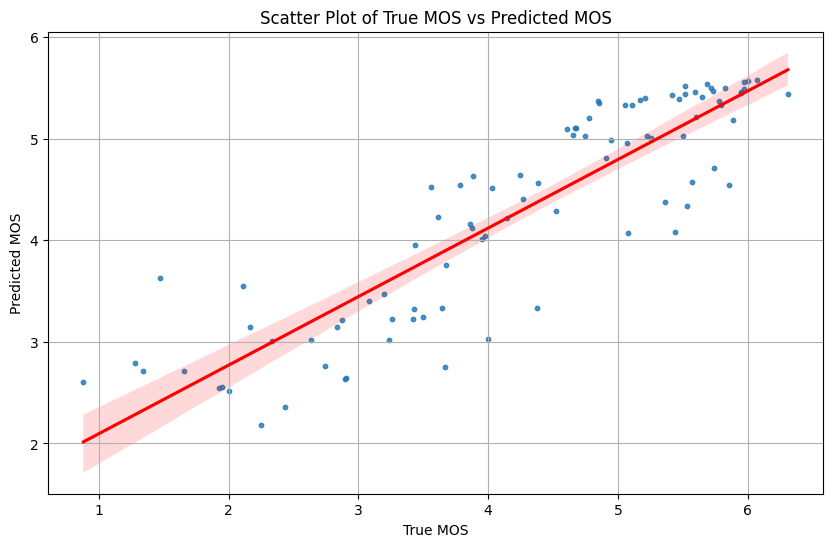

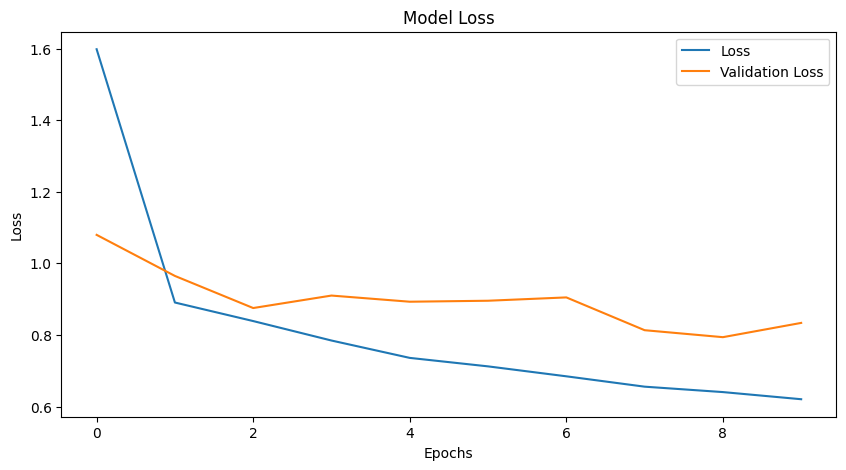

In [18]:
# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='MOS', y='Predicted_MOS', data=test_images_mos, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.xlabel('True MOS')
plt.ylabel('Predicted MOS')
plt.title('Scatter Plot of True MOS vs Predicted MOS')
plt.grid(True)
plt.show()

y_pred = test_predictions
y_true = test_generator.labels
# Training progress (loss minimization)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()